In [1]:
import pandas as pd
import numpy as np

# To Visualize Data
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
import xgboost as xgb

# To Train our data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# To evaluate end result we have
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import sys
import warnings

warnings.filterwarnings('ignore')

c:\Users\IRONMAN\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sys.path.insert(1, "../scripts")
from ml_processors import ML_Processor as MLP
from models import ML_Models

mlp = MLP()
mlm = ML_Models()

In [3]:
fb_data =  pd.read_csv('../data/facebook_data.csv')
ch_data =  pd.read_csv('../data/chrome_data.csv')
cm_data =  pd.read_csv('../data/chrome_mobile_webview_data.csv')
pt5_data =  pd.read_csv('../data/platform_5.csv')
pt6_data =  pd.read_csv('../data/platform_6.csv')

In [4]:

# separating categorical and numerical variables

cat2, num2 = mlp.sep_cat_num(fb_data)
cat3, num3 = mlp.sep_cat_num(ch_data)
cat4, num4 = mlp.sep_cat_num(cm_data)
cat5, num5 = mlp.sep_cat_num(pt5_data)
cat6, num6 = mlp.sep_cat_num(pt6_data)

In [5]:
def processor_pipe(categories):
    pipe_1 = Pipeline(
        steps=[
            ("label categories", FunctionTransformer(mlp.cat_labeler, kw_args={"cat_cols": categories})),
            ("scale data", FunctionTransformer(mlp.scaler)),
            ("separate target and features", FunctionTransformer(mlp.target_feature, kw_args={"f_r": [0, 6], "t":-1})),
            ("divide dataset", FunctionTransformer(mlp.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8})),      
            ])
    return pipe_1

pipe_1 = processor_pipe(cat2)
pipe_2 = processor_pipe(cat5)

sets = pipe_1.fit_transform(fb_data)


catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [6]:
sets2 = pipe_1.fit_transform(ch_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [7]:

sets3 = pipe_1.fit_transform(cm_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [8]:

sets4 = pipe_2.fit_transform(pt5_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [9]:

sets5 = pipe_2.fit_transform(pt6_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [10]:
model = XGBClassifier(
        learning_rate =0.08,
        n_estimators=1000,
        eval_metric='rmse',
        )
kfold_validation=KFold(5)

In [11]:
mlm.cross_val(fb_data, model, globals(), kfold_validation, [0, 6], -1)

Result of fb_data

[0.53125    0.51612903 0.35483871 0.58064516 0.51612903]
0.4997983870967742 

#################################




In [12]:
mlm.cross_val(ch_data, model, globals(), kfold_validation, [0, 6], -1)

Result of ch_data

[0.46043165 0.55395683 0.43884892 0.49640288 0.5323741 ]
0.49640287769784164 

#################################




In [13]:
mlm.cross_val(cm_data, model, globals(), kfold_validation, [0, 6], -1)

Result of cm_data

[0.41304348 0.47826087 0.51111111 0.62222222 0.66666667]
0.5382608695652173 

#################################




In [14]:
mlm.cross_val(pt5_data, model, globals(), kfold_validation, [0, 6], -1)

Result of pt5_data

[0.51219512 0.45714286 0.46938776 0.49795918 0.51020408]
0.489377799900448 

#################################




In [15]:
mlm.cross_val(pt6_data, model, globals(), kfold_validation, [0, 6], -1)

Result of pt6_data

[0.75       0.75       0.66666667 0.33333333 0.33333333]
0.5666666666666667 

#################################




In [16]:
# generate model

model = mlm.xgb_model(sets[0], sets[1], sets[2], sets[3])
model2 = mlm.xgb_model(sets2[0], sets2[1], sets2[2], sets2[3])
model3 = mlm.xgb_model(sets3[0], sets3[1], sets3[2], sets3[3])
model4 = mlm.xgb_model(sets4[0], sets4[1], sets4[2], sets4[3])
model5 = mlm.xgb_model(sets5[0], sets5[1], sets5[2], sets5[3])



2022/05/21 12:16:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7f6b46e4347848919b29197fe5c3b37e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2022/05/21 12:16:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9746433397e04e528bcc9486eb88d225', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2022/05/21 12:16:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '98e1e2f6a1604b748a7456634d545464', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2022/05/21 12:17:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5d3c6445426e4fab9cb8ae72706c9c37', which will track hyperparameters, performance metrics, model artifacts, and lineage i

The model accuracy is:  0.625


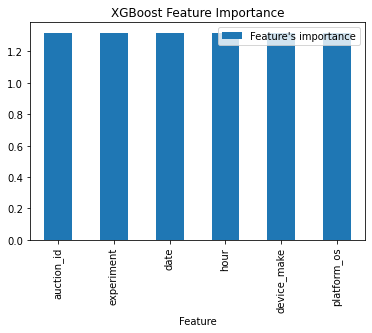

In [17]:
mlm.evaluate_model(model, fb_data, sets[2], sets[3], "XGBoost", globals())

The model accuracy is:  0.4714285714285714


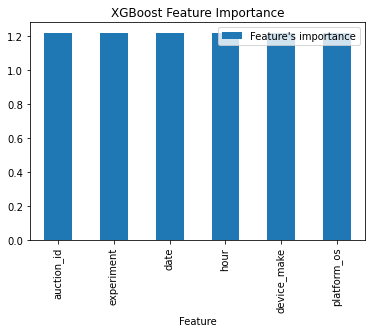

In [18]:
mlm.evaluate_model(model2, ch_data, sets2[2], sets2[3], "XGBoost", globals())

The model accuracy is:  0.5652173913043478


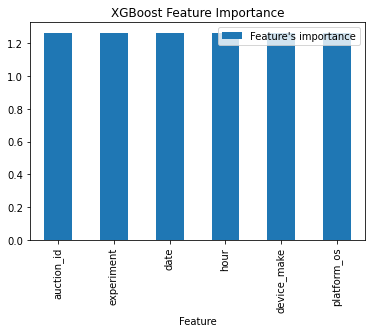

In [19]:
mlm.evaluate_model(model3, cm_data, sets3[2], sets3[3], "XGBoost", globals())

The model accuracy is:  0.6260162601626016


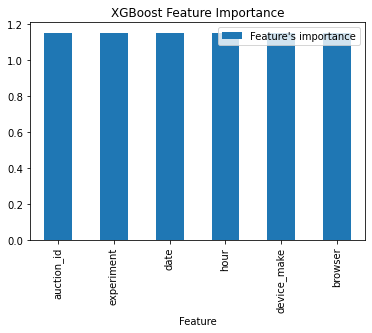

In [20]:
mlm.evaluate_model(model4, pt5_data, sets4[2], sets4[3], "XGBoost", globals())

The model accuracy is:  0.5


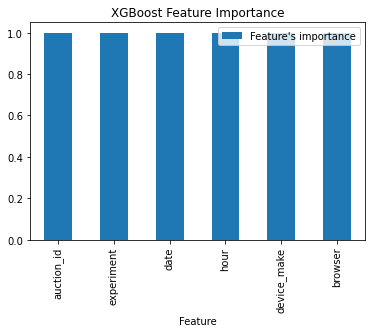

In [21]:
mlm.evaluate_model(model5, pt6_data, sets5[2], sets5[3], "XGBoost", globals())